In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import math
from datetime import date, timedelta
from numpy import sqrt,mean,log,diff
from matplotlib import pyplot as plt
import unittest
import seaborn as sns
import heapq
from sympy import symbols, solve, Eq
import json 

In [2]:
def open_file(qq):
    data_list = []
    name = str(qq) + '.csv'
    with open(name, 'r') as reading:
        file_input = reading.read().split('\n')

    for row in file_input:
        data_list.append(row.split('\t'))
    data = pd.DataFrame(data_list,columns=['date', 'open', 'high', 'low', 'close', 'vol'])
    data['close'] = pd.to_numeric(data['close'],errors = 'coerce')
    data['vol'] = pd.to_numeric(data['vol'],errors = 'coerce')
    return data

def get_rate_and_volume(data_file_name, V, start_date, end_date):
    exchange_rate = list()
    volume = list()
    for i, single_date in enumerate(daterange(start_date, end_date)):
        a_date = single_date.isoformat()+str(' 00:00')
        if a_date not in open_file(data_file_name)['date'].values:
            a_date = (single_date-timedelta(days=1)).isoformat()+str(' 00:00')
        print(a_date)
        exchange_rate.append(float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['close'].values))
        exchange_rate.append(V * float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['vol']))
    return exchange_rate, volume

In [3]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 31)
pairs = ['EURUSD', 'AUDUSD', 'GBPUSD', 'NZDUSD']
V = 100

In [4]:
exchange_rates_array = list()
volumes_array = list()
dates_array = list()
foreign_risk_free_rate = list()
domestic_risk_free_rate = list()

for pair_index in range(len(pairs)):
    data_file_name = 'data/' + pairs[pair_index] + '1440'
    data = open_file(data_file_name)
    dates = data['date'].values
    dates = [x[:-6] for x in dates]
    exchange_rates = data['close'].values
    volumes = data['vol'].values
    start_index = [i for i in range(len(dates)) if dates[i] == str(start_date)][0]
    end_index = [i for i in range(len(dates)) if dates[i] == str(end_date)][0]
    dates_array.append(dates[start_index:end_index+1])
    exchange_rates_array.append(exchange_rates[start_index:end_index+1])
    volumes_array.append(volumes[start_index:end_index+1])

exchange_rates_array = np.array(exchange_rates_array)
volumes_array = np.array(volumes_array)

In [5]:
print(np.shape(exchange_rates_array))
print(np.cov(exchange_rates_array))
print(np.corrcoef(exchange_rates_array))

(4, 314)
[[0.00198052 0.0016558  0.00133738 0.0012721 ]
 [0.0016558  0.00169787 0.00137727 0.00130886]
 [0.00133738 0.00137727 0.00163975 0.00118338]
 [0.0012721  0.00130886 0.00118338 0.00109828]]
[[1.         0.90295525 0.74212144 0.86252955]
 [0.90295525 1.         0.8254235  0.95848165]
 [0.74212144 0.8254235  1.         0.88181901]
 [0.86252955 0.95848165 0.88181901 1.        ]]


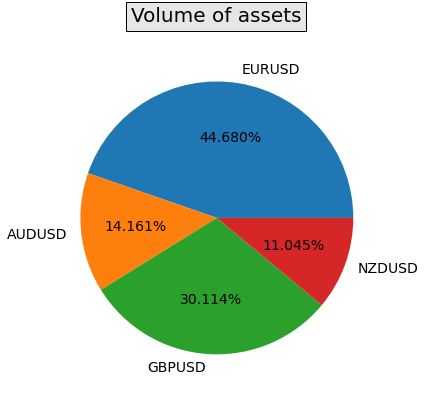

In [6]:
fig = plt.figure(figsize=(6,6))
plt.pie(np.sum(volumes_array, axis=1), labels=pairs,autopct='%1.3f%%', radius = 2, textprops={'fontsize': 14})
plt.title("Volume of assets", bbox={'facecolor':'0.9', 'pad':5}, fontsize = 20)
plt.axis('equal')
plt.tight_layout()
plt.show()

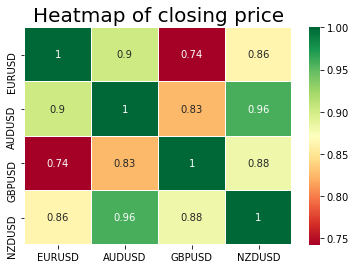

In [7]:
exchange_rates_pd = pd.DataFrame(exchange_rates_array.transpose(), columns = pairs)

ax = sns.heatmap(exchange_rates_pd.corr(), cmap='RdYlGn', linewidths=.1,annot=True)
plt.title("Heatmap of closing price", fontsize = 20)
plt.show()

## Discrete tokenization

In [8]:
class Discrete:
    def __init__(self, A0, N0, k0):
        self.A = A0.astype(int)
        self.N = N0
        self.k = k0


    def preprocess(self):
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        a_star = np.sort(self.A, axis=None)
        largest_ele_index = heapq.nlargest(self.k-1, range(len(a_star)))
        sum_ar = 0
        for i in range(0, len(a_star)):
            if i not in largest_ele_index:
                sum_ar = sum_ar + np.sum(a_star[i])
        B = 0
        n = 2
        a_star_res = a_star
        for start in range(self.N - self.k+1,self.N):
            index_S_inner = self.N-self.k+n-1
            S_inner = np.sum(a_star[0:index_S_inner])
            if math.floor(S_inner/(n-1)) >= A[self.N-self.k+n-1]:
                a_star_res[self.N-self.k+n-1] = A[self.N-self.k+n-1]
                sum_ar = sum_ar + a_star_res[index_S_inner]
            else:
                a_star_res[self.N-self.k+n-1] = math.floor(S_inner/(n-1))
                sum_ar = sum_ar + a_star_res[index_S_inner]
            delta = A[index_S_inner] - a_star_res[index_S_inner]
            B = B + delta
            n = n+1
        return a_star_res, B


    def distribution(self, a_star_res, B, return_distribution_matrix=False, print_results=False):
        if print_results:
            print("-------------------------")
        S = np.sum(a_star_res)
        M_star = math.floor(S/self.k)
        B0 = abs(S - M_star*self.k)
        n = self.N - B0 +1
        for n in range(n, self.N+1):
            a_star_res[n-1] = a_star_res[n-1] - 1
            B = B + B0
        I_n = np.zeros(self.N+1)
        r_n = np.zeros(self.N+1)
        for n in range(1,self.N+1):
            I_n[n] = np.sum(a_star_res[0:n-1])+1
            r_n[n] = np.sum(a_star_res[0:n])
        if print_results:
            print("a_star is", a_star_res)
        if return_distribution_matrix:
            my_matrix = np.zeros((self.k, M_star))
            n = 1
            for i in range(1, M_star + 1):
                for j in range(1, self.k+1):
                    check_index = i + M_star * (j - 1)
                    for n in range(1, self.N+1):
                        if check_index <= r_n[n] and check_index >= I_n[n]:
                            my_matrix[j-1, i-1] = self.inverse_sort_indexes[n-1] + 1
                        n =n+1
            if print_results:
                print("optimal tokenization by algorithm 1 is\n", my_matrix)
            return a_star_res[self.inverse_sort_indexes], my_matrix
        else:
            return a_star_res[self.inverse_sort_indexes]

In [9]:
# test example

A = np.array([3, 4, 3, 5, 7, 2]) # np.array([1,3,4,5,6,7,8]) # 
N = len(A)
k = 4
my_res_1 = Discrete(A, N, k)
res_1, my_B= my_res_1.preprocess()
a_star_res, my_matrix = my_res_1.distribution(res_1, my_B, return_distribution_matrix=True)
print('A:', A)
print('a_star:', a_star_res)
print('my_matrix:', my_matrix)

my_res_1 = Discrete(A, N, k)
res_1, my_B= my_res_1.preprocess()
a_star_res = my_res_1.distribution(res_1, my_B)

A: [3 4 3 5 7 2]
a_star: [3 4 3 4 4 2]
my_matrix: [[2. 2. 4. 4. 4.]
 [3. 3. 3. 5. 5.]
 [5. 5. 6. 6. 6.]
 [6. 1. 1. 1. 1.]]


In [10]:
np.floor(volumes_array[:, 0])
k = 3
A = np.floor(volumes_array[:, 0]).astype(int) * k
N = len(A)
my_res_1 = Discrete(A, N, k)
res_1, my_B= my_res_1.preprocess()
a_star_res = my_res_1.distribution(res_1, my_B)
print(volumes_array[:, 0])
print(a_star_res.astype(float) / k)

[ 2631.  3364. 13079.  3966.]
[2631. 3364. 4980. 3966.]


In [11]:
k = 3
N = len(pairs)

tokenized_volume = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = np.floor(volumes_array[:, trading_day_index]).astype(int) * k
    my_res_1 = Discrete(A, N, k)
    res_1, my_B= my_res_1.preprocess()
    a_star_res = my_res_1.distribution(res_1, my_B) / k
    tokenized_volume[trading_day_index] = np.sum(a_star_res)

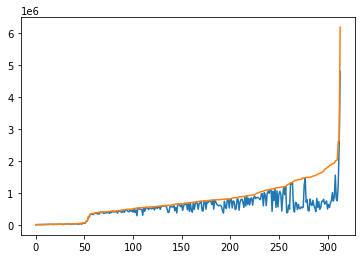

In [12]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(tokenized_volume[sort_indexes])
plt.plot(np.sum(volumes_array, axis=0)[sort_indexes])

Tokenized fraction:  0.7061052803816608


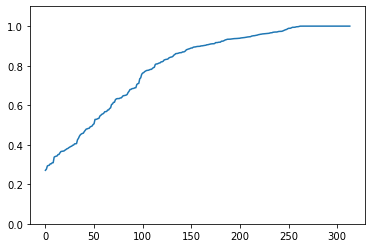

In [13]:
data_to_plot_discrete = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]


plt.plot(np.sort(data_to_plot_discrete))
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.ylim([0,1.1])
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [14]:
covariances = np.cov(exchange_rates_array)
allowed_package_covariance = np.zeros((len(pairs),))
for index in range(len(pairs)):
    vector = np.ones((len(pairs),)) / k
    vector[index] = 0
    current_covariance = np.matmul(np.matmul(vector, covariances), vector)
    allowed_package_covariance[index] = current_covariance
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(allowed_package_covariance))
print("(Minium) Reduction factor vs k: ", (np.max(covariances) / np.max(allowed_package_covariance)), ' vs ', k)

Max covariance:  0.0019805239767943265
Max package variance:  0.0015621152653092349
(Minium) Reduction factor vs k:  1.2678475275012846  vs  3


## Continuous tokenization

In [15]:
class Continuous:
    def __init__(self, N0, A0, target_var_reduc):
        self.A = A0
        self.N = N0
        self.var = target_var_reduc

    def search(self):
        N = self.N
        var = self.var
        E = np.array([0],dtype='float64')
        V = np.array([0],dtype='float64')
        a_n = np.zeros(self.N)
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        A = np.insert(A, 0, 0)
        for n in range(0, N):
            E_new = E + (N-n)*(A[n+1] - A[n])
            V_new = V + (N-n)*(A[n+1]**2 - A[n]**2)
            check = (1/var)*(E_new)**2
            if check >= V_new:
                E = E_new
                V = V_new
                for k in range(n+1-1, N):
                    a_n[k] = A[n+1]
            else:
                x = symbols('x')
                E_new = E + (N-n)*(A[n+1] - A[n])
                expr = (1/var)*(E + (N - n)*(x - A[n]))**2 - V - (N - n) * (x**2 - A[n]**2)
                A_sol = solve(expr)
                A_sol =  min(list(A_sol[1].values())[0], A[n + 1])
                E = E + (N-n)*(A_sol - A[n])
                V = V + (N-n)*(A_sol**2 - A[n]**2)
                n_star = n + 1
                for k in range(n_star-1, N):
                    a_n[k] = A_sol
        return a_n[self.inverse_sort_indexes]

    def construct_pack(self, a_n):
        M = np.linalg.norm((a_n), ord=1)
        composition  = a_n/M
        return  composition
    
    
                #a = (1/var) * (N - n) - (N - n)
                #b = 2 * (1/var) * (N - n) * (-E_new + (N - n)* A[n+1])
                #c = (1/var) * (E_new - A[n+1] * (N - n))**2 - (N - n) * A[n+1]**2

                # calculate the discriminant
                #d = (b**2) - (4*a*c)

                # find bigger solution
                #A_sol = (-b+np.sqrt(d))/(2*a)

In [16]:
    # test example
    A = np.array([3,2,7,4,9]) # np.array([3,4,5])#np.array([2,3,7,4,9]) #np.array([1,2,4])
    N = len(A)

    my_var = np.var(A)
    length = len(A)
    my_min = np.min(A)
    my_max = np.max(A)
    rand1 = np.random.randint(my_min, my_max + 1, size=length)
    rand2 = np.random.randint(my_min, my_max + 1, size=length)
    cov_rand = np.cov(rand1, rand2)[0, 0]
    var_red = cov_rand/my_var

    my_res_2 = Continuous(N, A, var_red)
    res_1 = my_res_2.search()
    print("final a_n = ", res_1)
    res_2 = my_res_2.construct_pack(res_1)
    print("composition is", res_2)

final a_n =  [3. 2. 7. 4. 9.]
composition is [0.12 0.08 0.28 0.16 0.36]


In [17]:
# test example

k = 3

A = np.array([1000, 1, 1, 1])
my_res_2 = Continuous(len(A), A, k)
print
res_1 = my_res_2.search()
res_2 = my_res_2.construct_pack(res_1)
print(res_1)
print(res_2)

[3. 1. 1. 1.]
[0.5        0.16666667 0.16666667 0.16666667]


In [18]:
k = 3
N = len(pairs)

tokenized_volume = np.zeros((volumes_array.shape[1],))
package_variance = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = volumes_array[:, trading_day_index]
    my_res_2 = Continuous(N, A, k)
    res_1 = my_res_2.search()
    res_2 = my_res_2.construct_pack(res_1)
    tokenized_volume[trading_day_index] = np.sum(res_1)
    package_variance[trading_day_index] = np.matmul(np.matmul(res_2, covariances), res_2)

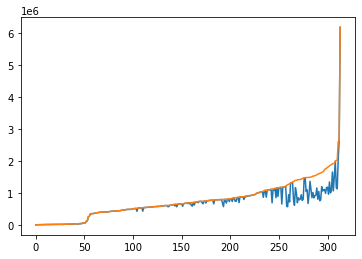

In [19]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(tokenized_volume[sort_indexes])
plt.plot(np.sum(volumes_array, axis=0)[sort_indexes])

Tokenized fraction:  0.8623487679062549


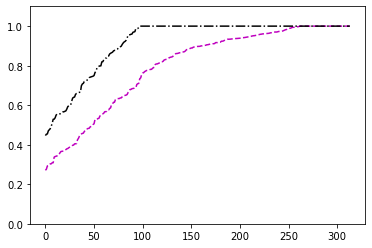

In [20]:
data_to_plot_continuous = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]

plt.plot(np.sort(data_to_plot_discrete), '--m')
plt.plot(np.sort(data_to_plot_continuous), '-.k')
plt.ylim([0,1.1])
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [21]:
covariances = np.cov(exchange_rates_array)
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(package_variance))
print("(Minium) Reduction factor vs k: ", (np.max(covariances) / np.max(package_variance)), ' vs ', k)

Max covariance:  0.0019805239767943265
Max package variance:  0.0016173814983811013
(Minium) Reduction factor vs k:  1.2245249366192876  vs  3


## Information for blockchain

In [22]:
trading_day_index = 0
dict_for_blockchain = dict()
dict_for_blockchain['trading_day'] = dates_array[0][trading_day_index]

k = 3
A = volumes_array[:, trading_day_index]
my_res_2 = Continuous(len(A), A, k)
res_1 = my_res_2.search()
res_2 = my_res_2.construct_pack(res_1)
dict_for_blockchain['packages_number'] = round(sum(res_1))
dict_for_blockchain['package_content'] = list(res_2)
dict_for_blockchain['pairs'] = pairs

json_for_blockchain = json.dumps(dict_for_blockchain, indent = 4)  
print(json_for_blockchain)

{
    "trading_day": "2020-01-01",
    "packages_number": 19786,
    "package_content": [
        0.13297611027629772,
        0.1700234264422142,
        0.4965507280645376,
        0.2004497352169505
    ],
    "pairs": [
        "EURUSD",
        "AUDUSD",
        "GBPUSD",
        "NZDUSD"
    ]
}
